In [1285]:
import os
import re
import sys
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from invisible_cities.database  import load_db
from invisible_cities.io.dst_io import load_dst
from invisible_cities.io.dst_io import df_writer

In [1286]:
# Load in the files
lt_dir = os.path.expandvars("../files/S1_temp/")
# lt_dir = os.path.expandvars("../config/")
lt_filenames = glob.glob(os.path.join(lt_dir, "*.h5"))
lt_filenames = sorted(lt_filenames)
print(lt_filenames)

# Configure the detector database
detector_db = "new"
datapmt = load_db.DataPMT(detector_db, 0)
xpmt, ypmt = datapmt["X"].values, datapmt["Y"].values
sensorids  = datapmt["SensorID"].values

['../files/S1_temp/NEW_S1_LT_1.next.h5', '../files/S1_temp/NEW_S1_LT_10.next.h5', '../files/S1_temp/NEW_S1_LT_100.next.h5', '../files/S1_temp/NEW_S1_LT_11.next.h5', '../files/S1_temp/NEW_S1_LT_12.next.h5', '../files/S1_temp/NEW_S1_LT_13.next.h5', '../files/S1_temp/NEW_S1_LT_14.next.h5', '../files/S1_temp/NEW_S1_LT_15.next.h5', '../files/S1_temp/NEW_S1_LT_16.next.h5', '../files/S1_temp/NEW_S1_LT_17.next.h5', '../files/S1_temp/NEW_S1_LT_18.next.h5', '../files/S1_temp/NEW_S1_LT_19.next.h5', '../files/S1_temp/NEW_S1_LT_2.next.h5', '../files/S1_temp/NEW_S1_LT_20.next.h5', '../files/S1_temp/NEW_S1_LT_21.next.h5', '../files/S1_temp/NEW_S1_LT_22.next.h5', '../files/S1_temp/NEW_S1_LT_23.next.h5', '../files/S1_temp/NEW_S1_LT_24.next.h5', '../files/S1_temp/NEW_S1_LT_25.next.h5', '../files/S1_temp/NEW_S1_LT_26.next.h5', '../files/S1_temp/NEW_S1_LT_27.next.h5', '../files/S1_temp/NEW_S1_LT_28.next.h5', '../files/S1_temp/NEW_S1_LT_29.next.h5', '../files/S1_temp/NEW_S1_LT_3.next.h5', '../files/S1_temp

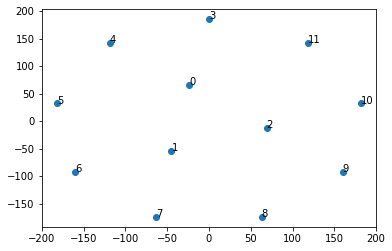

In [1287]:
plt.scatter(xpmt, ypmt)
for x, y, sid  in zip(xpmt, ypmt, sensorids):
    plt.annotate(sid, (x, y))

In [1288]:
filename = lt_filenames[0]
print(filename)
parts = pd.read_hdf(filename, 'MC/particles')
parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]
display(parts.head(10))


../files/S1_temp/NEW_S1_LT_1.next.h5


,event_id,initial_x,initial_y,initial_z
0,100,-64.291519,-33.851116,357.888550
1,101,-57.908047,-182.549515,220.690140
2,102,55.742599,-124.422577,305.358887
3,103,29.687824,103.638870,499.422363
4,104,128.246384,124.344307,277.658386
5,105,104.762199,68.912193,124.475212
6,106,-93.461655,176.153412,21.139490
7,107,34.848850,-159.153793,375.195526
8,108,-23.086290,-59.359562,367.774689
9,109,-135.283295,-69.965630,196.349304


In [1289]:
# Get the metadata from the files
configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
num_events = int(configuration.loc["num_events"][0])
nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

sns_response  = pd.read_hdf(filename, "MC/sns_response")
pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]

pd.set_option('display.max_rows', None)
# display(pmt_response)
display(pmt_response.head(10))

,event_id,sensor_id,time_bin,charge
344,100,5,0,1008
345,100,5,1,1
346,100,2,0,1393
347,100,2,1,1
348,100,1,0,1442
349,100,1,1,2
350,100,7,0,1079
351,100,3,0,946
352,100,3,1,1
353,100,8,0,939


In [1290]:
# protection time bins
pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()
display(pmt_response.head(11))

,sensor_id,event_id,charge
0,0,100,1393
1,0,101,1084
2,0,102,1295
3,0,103,1965
4,0,104,1234
5,0,105,955
6,0,106,700
7,0,107,1401
8,0,108,1452
9,0,109,1072


In [1291]:
# Merge the dataframes to add the x, y, z positions
pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')
display(pmt_response.head(10))

,sensor_id,event_id,charge,initial_x,initial_y,initial_z
0,0,100,1393,-64.291519,-33.851116,357.88855
1,1,100,1444,-64.291519,-33.851116,357.88855
2,2,100,1394,-64.291519,-33.851116,357.88855
3,3,100,947,-64.291519,-33.851116,357.88855
4,4,100,974,-64.291519,-33.851116,357.88855
5,5,100,1009,-64.291519,-33.851116,357.88855
6,6,100,994,-64.291519,-33.851116,357.88855
7,7,100,1079,-64.291519,-33.851116,357.88855
8,8,100,943,-64.291519,-33.851116,357.88855
9,9,100,998,-64.291519,-33.851116,357.88855


In [1292]:
# Set the Binning
xmin=-200
xmax=200
xbw=20

zmin=0
zmax=700
zbw=50

xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = xbins
zbins = np.arange(zmin, zmax+zbw, zbw)

xbins_centre = np.arange(xmin+xbw/2, xmax+xbw/2, xbw)
ybins_centre = xbins_centre
zbins_centre = np.arange(zmin+zbw/2, zmax+zbw/2, zbw)

print(xbins)
print(xbins_centre)



[-200 -180 -160 -140 -120 -100  -80  -60  -40  -20    0   20   40   60
   80  100  120  140  160  180  200]
[-190. -170. -150. -130. -110.  -90.  -70.  -50.  -30.  -10.   10.   30.
   50.   70.   90.  110.  130.  150.  170.  190.]


In [1293]:
# Now bin the x, y, z positions
pmt_response['x'] = pd.cut(x=pmt_response['initial_x'], bins=xbins,labels=xbins_centre, include_lowest=True)
pmt_response['y'] = pd.cut(x=pmt_response['initial_y'], bins=ybins,labels=ybins_centre, include_lowest=True)
pmt_response['z'] = pd.cut(x=pmt_response['initial_z'], bins=zbins,labels=zbins_centre, include_lowest=True)

 # remove the initial x,y,z since we are done with them
pmt_response = pmt_response.drop(columns=['initial_x', 'initial_y', 'initial_z'])

In [1294]:
# Normalise the charge in each PMT by the total number of photons simulated
pmt_response['charge'] = pmt_response['charge']/nphotons

LT = pmt_response

# LT  = pd.pivot_table(pmt_response , values="charge", columns="sensor_id", index=["x", "y", "z"])

display(LT.head(10))

,sensor_id,event_id,charge,x,y,z
0,0,100,0.001393,-70.0,-30.0,375.0
1,1,100,0.001444,-70.0,-30.0,375.0
2,2,100,0.001394,-70.0,-30.0,375.0
3,3,100,0.000947,-70.0,-30.0,375.0
4,4,100,0.000974,-70.0,-30.0,375.0
5,5,100,0.001009,-70.0,-30.0,375.0
6,6,100,0.000994,-70.0,-30.0,375.0
7,7,100,0.001079,-70.0,-30.0,375.0
8,8,100,0.000943,-70.0,-30.0,375.0
9,9,100,0.000998,-70.0,-30.0,375.0


In [1295]:
LT  = pd.DataFrame()
ERR = pd.DataFrame()

for i, filename in enumerate(lt_filenames, 1):
    sys.stdout.write(f"Processing file {i}/{len(lt_filenames)} \r")
    sys.stdout.flush()
    
    configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
    num_events = int(configuration.loc["num_events"][0])
    nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

    sns_response  = pd.read_hdf(filename, "MC/sns_response")
    pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]
    
    # protection time bins
    pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()

    # Load in the MC Particles
    parts = pd.read_hdf(filename, 'MC/particles')
    parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]

    # Merge the dataframes
    pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')

    # Now bin the x, y, z positions
    pmt_response['x'] = pd.cut(x=pmt_response['initial_x'], bins=xbins,labels=xbins_centre, include_lowest=True)
    pmt_response['y'] = pd.cut(x=pmt_response['initial_y'], bins=ybins,labels=ybins_centre, include_lowest=True)
    pmt_response['z'] = pd.cut(x=pmt_response['initial_z'], bins=zbins,labels=zbins_centre, include_lowest=True)

    # remove the initial x,y,z since we are done with them
    pmt_response = pmt_response.drop(columns=['initial_x', 'initial_y', 'initial_z'])

    # Normalise the charge in each PMT by the total number of photons simulated
    pmt_response['charge'] = pmt_response['charge']/nphotons
    
    LT  = pd.concat([LT , pmt_response])
    # ERR = pd.concat([ERR, err])



In [1296]:
lt = LT.groupby(["sensor_id", "x", "y", "z"])["charge"].sum().to_frame().reset_index()
display(lt.head(10))

,sensor_id,x,y,z,charge
0,0,-190.0,-190.0,25.0,NaN
1,0,-190.0,-190.0,75.0,NaN
2,0,-190.0,-190.0,125.0,NaN
3,0,-190.0,-190.0,175.0,NaN
4,0,-190.0,-190.0,225.0,NaN
5,0,-190.0,-190.0,275.0,NaN
6,0,-190.0,-190.0,325.0,NaN
7,0,-190.0,-190.0,375.0,NaN
8,0,-190.0,-190.0,425.0,NaN
9,0,-190.0,-190.0,475.0,NaN


In [1297]:
LT  = pd.pivot_table(lt, values="charge", columns="sensor_id", index=["x", "y", "z"])
display(LT.head(10))

sensor_id                 0         1         2         3         4   \
x      y     z                                                         
-190.0 -90.0 25.0   0.000679  0.000660  0.000689  0.000574  0.000598   
             75.0   0.000844  0.000847  0.000814  0.000648  0.000736   
             125.0  0.001017  0.000884  0.000989  0.000716  0.000788   
             225.0  0.001035  0.001051  0.001092  0.000789  0.000882   
             325.0  0.002660  0.002710  0.002582  0.001930  0.001930   
             425.0  0.001434  0.001771  0.001453  0.000940  0.001062   
       -70.0 75.0   0.000771  0.000786  0.000807  0.000626  0.000690   
             125.0  0.001878  0.001853  0.001996  0.001449  0.001578   
             225.0  0.003448  0.003329  0.003424  0.002586  0.002712   
             325.0  0.003822  0.004001  0.003773  0.002887  0.003086   

sensor_id                 5         6         7         8         9   \
x      y     z                                                         
-190.0 -90.0 25.0   0.000569  0.000512  0.000585  0.000605  0.000553   
             75.0   0.000700  0.000649  0.000735  0.000724  0.000682   
             125.0  0.000810  0.000746  0.000801  0.000813  0.000722   
             225.0  0.000857  0.000869  0.000851  0.000848  0.000831   
             325.0  0.002198  0.002185  0.002140  0.001959  0.001942   
             425.0  0.001347  0.001459  0.001282  0.001045  0.000947   
       -70.0 75.0   0.000641  0.000605  0.000707  0.000695  0.000657   
             125.0  0.001517  0.001410  0.001490  0.001486  0.001449   
             225.0  0.002760  0.002652  0.002832  0.002579  0.002627   
             325.0  0.003196  0.003075  0.003147  0.002797  0.002857   

sensor_id                 10        11  
x      y     z                          
-190.0 -90.0 25.0   0.000579  0.000520  
             75.0   0.000612  0.000638  
             125.0  0.000771  0.000728  
             225.0  0.000811  0.000798  
             325.0  0.001821  0.001880  
             425.0  0.000961  0.000893  
       -70.0 75.0   0.000644  0.000574  
             125.0  0.001407  0.001385  
             225.0  0.002446  0.002532  
             325.0  0.002857  0.002725

In [1298]:
LT.columns = LT.columns.rename("")
# ERR.columns = err.columns.rename("")

LT  = LT.reset_index()
display(lt.head(10))
err = ERR.reset_index()

,sensor_id,x,y,z,charge
0,0,-190.0,-190.0,25.0,NaN
1,0,-190.0,-190.0,75.0,NaN
2,0,-190.0,-190.0,125.0,NaN
3,0,-190.0,-190.0,175.0,NaN
4,0,-190.0,-190.0,225.0,NaN
5,0,-190.0,-190.0,275.0,NaN
6,0,-190.0,-190.0,325.0,NaN
7,0,-190.0,-190.0,375.0,NaN
8,0,-190.0,-190.0,425.0,NaN
9,0,-190.0,-190.0,475.0,NaN


In [1299]:
pmt = "PmtR11410"
signal_type = "S1"

for sid in sensorids:
    LT = LT.rename({sid: pmt + f"_{sid}"}, axis=1)
LT[pmt + f"_total"] = LT.loc[:, LT.columns.difference(["x", "y", "z"])].sum(axis=1)

if signal_type == "S2":
    LT = LT.drop("z", axis=1)

display(LT.tail(10))

,x,y,z,PmtR11410_0,PmtR11410_1,PmtR11410_2,PmtR11410_3,PmtR11410_4,PmtR11410_5,PmtR11410_6,PmtR11410_7,PmtR11410_8,PmtR11410_9,PmtR11410_10,PmtR11410_11,PmtR11410_total
3473,190.0,70.0,275.0,0.002482,0.002480,0.002572,0.001953,0.001853,0.001780,0.001846,0.001816,0.001816,0.002060,0.001941,0.002031,0.024630
3474,190.0,70.0,475.0,0.001486,0.001373,0.001811,0.001154,0.000934,0.000904,0.000922,0.000855,0.001008,0.001361,0.001602,0.001508,0.014918
3475,190.0,70.0,375.0,0.004126,0.004056,0.004393,0.003141,0.002932,0.002855,0.002814,0.002933,0.003057,0.003428,0.003456,0.003466,0.040657
3476,190.0,90.0,25.0,0.000726,0.000793,0.000736,0.000623,0.000603,0.000590,0.000551,0.000567,0.000627,0.000652,0.000580,0.000616,0.007664
3477,190.0,90.0,75.0,0.001677,0.001723,0.001653,0.001350,0.001356,0.001310,0.001321,0.001219,0.001388,0.001387,0.001298,0.001354,0.017036
3478,190.0,90.0,125.0,0.000993,0.000969,0.000914,0.000845,0.000732,0.000728,0.000663,0.000724,0.000802,0.000785,0.000725,0.000762,0.009642
3479,190.0,90.0,225.0,0.001159,0.001155,0.001226,0.000987,0.000918,0.000891,0.000884,0.000894,0.000960,0.000943,0.000892,0.000951,0.011860
3480,190.0,90.0,475.0,0.003151,0.002668,0.003671,0.002444,0.001866,0.001714,0.001749,0.001746,0.001979,0.002521,0.003828,0.003435,0.030772
3481,190.0,90.0,525.0,0.001588,0.001286,0.001935,0.001196,0.000935,0.000811,0.000798,0.000874,0.001014,0.001331,0.002013,0.001775,0.015556
3482,190.0,90.0,375.0,0.001447,0.001328,0.001608,0.001120,0.000975,0.000957,0.000923,0.000892,0.001003,0.001150,0.001257,0.001228,0.013888


In [1300]:
save = True
outfilename = f"NEW-MC_{signal_type}_LT.h5"

if save:
    with tb.open_file(outfilename, 'w') as h5out:
        df_writer(h5out, LT, "LT", "LightTable")

In [1301]:
# create config
config = { "detector"   : "new"
         , "ACTIVE_rad" : str(227)
         , "EL_GAP"     : str(6.0)
         , "table_type" : "energy"
         , "signal_type": signal_type
         , "sensor"     : pmt
         , "pitch_x"    : str(10)
         , "pitch_y"    : str(10)}

config = pd.DataFrame({"parameter": config.keys(), "value": config.values()})
if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer(h5out, config, "LT", "Config")

In [1302]:
# lt     = load_dst("LT/NEW-MC_S1_LT.h5", "LT", "LightTable")
# config = load_dst("LT/NEW-MC_S1_LT.h5", "LT", "Config")

lt     = load_dst(outfilename, "LT", "LightTable")
config = load_dst(outfilename, "LT", "Config")

In [1303]:
display(lt.head(10))
display(config)

,x,y,z,PmtR11410_0,PmtR11410_1,PmtR11410_2,PmtR11410_3,PmtR11410_4,PmtR11410_5,PmtR11410_6,PmtR11410_7,PmtR11410_8,PmtR11410_9,PmtR11410_10,PmtR11410_11,PmtR11410_total
0,-190.0,-90.0,25.0,0.000679,0.000660,0.000689,0.000574,0.000598,0.000569,0.000512,0.000585,0.000605,0.000553,0.000579,0.000520,0.007123
1,-190.0,-90.0,75.0,0.000844,0.000847,0.000814,0.000648,0.000736,0.000700,0.000649,0.000735,0.000724,0.000682,0.000612,0.000638,0.008629
2,-190.0,-90.0,125.0,0.001017,0.000884,0.000989,0.000716,0.000788,0.000810,0.000746,0.000801,0.000813,0.000722,0.000771,0.000728,0.009785
3,-190.0,-90.0,225.0,0.001035,0.001051,0.001092,0.000789,0.000882,0.000857,0.000869,0.000851,0.000848,0.000831,0.000811,0.000798,0.010714
4,-190.0,-90.0,325.0,0.002660,0.002710,0.002582,0.001930,0.001930,0.002198,0.002185,0.002140,0.001959,0.001942,0.001821,0.001880,0.025937
5,-190.0,-90.0,425.0,0.001434,0.001771,0.001453,0.000940,0.001062,0.001347,0.001459,0.001282,0.001045,0.000947,0.000961,0.000893,0.014594
6,-190.0,-70.0,75.0,0.000771,0.000786,0.000807,0.000626,0.000690,0.000641,0.000605,0.000707,0.000695,0.000657,0.000644,0.000574,0.008203
7,-190.0,-70.0,125.0,0.001878,0.001853,0.001996,0.001449,0.001578,0.001517,0.001410,0.001490,0.001486,0.001449,0.001407,0.001385,0.018898
8,-190.0,-70.0,225.0,0.003448,0.003329,0.003424,0.002586,0.002712,0.002760,0.002652,0.002832,0.002579,0.002627,0.002446,0.002532,0.033927
9,-190.0,-70.0,325.0,0.003822,0.004001,0.003773,0.002887,0.003086,0.003196,0.003075,0.003147,0.002797,0.002857,0.002857,0.002725,0.038223


,parameter,value
0,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
1,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
2,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
3,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
4,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
5,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
6,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
7,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"


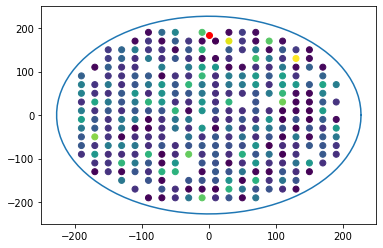

In [1304]:
z =325
sel = lt.z == z

sid = 3

plt.scatter(lt[sel].x, lt[sel].y, c=lt[sel][pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

# r = float(config.set_index("parameter").loc["ACTIVE_rad"])
r = 454/2
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

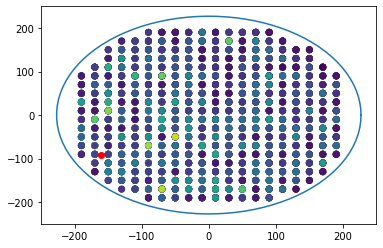

In [1305]:
sid = 6
plt.scatter(lt.x, lt.y, c=lt[pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

# r = float(config.set_index("parameter").loc["ACTIVE_rad"])
r = 454/2
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

In [1306]:
df_writer(h5out, conf_psf, "PSF", "Config", str_col_length = conf_psf.value.str.len().max())

NameError: name 'conf_psf' is not defined

In [ ]:
filename = "/mnt/lustre/scratch/home/usc/ie/gdl/NEXT100/LightTables/NEXT100_S2_LT.h5"

lt_ex  = load_dst(filename, "LT", "LightTable")
config = load_dst(filename, "LT", "Config")

In [ ]:
from invisible_cities.core.core_functions import binedges_from_bincenters
xbins = binedges_from_bincenters(np.unique(lt["x"]))
ybins = binedges_from_bincenters(np.unique(lt["y"]))

In [ ]:
sensor_id = 2

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 5])
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
# light table
h, _, _ = np.histogram2d(lt["x"], lt["y"], weights=lt[sensor_id], bins=[xbins, ybins])
im0 = ax0.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
# fig.colorbar(im0, ax=ax0)

# err
h, _, _ = np.histogram2d(err["x"], err["y"], weights=err[sensor_id], bins=[xbins, ybins])
im1 = ax1.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
fig.colorbar(im1, ax=ax1)

In [ ]:
sensor_id = 2

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_id])
ax1.scatter(err["x"], err["y"], c=err[sensor_id])

ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")

In [ ]:
old_table = os.path.expandvars("$LUSTRE/NEXT100/LightTables/NEXT100_S2_LT.h5")

from invisible_cities.io.dst_io import load_dst
old = load_dst(old_table, "LT", "LightTable")

In [ ]:
sensor_id = 31

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])

ax0.set_title("new")
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_id])


ax1.set_title("old")
ax1.scatter(old["x"], old["y"], c=old[f"PmtR11410_{sensor_id}"], s=3)


plt.figure()
_, bins, _ = plt.hist(old[f"PmtR11410_{sensor_id}"], bins=100 , density=True, histtype="step", linewidth=2)
_, _   , _ = plt.hist(lt[sensor_id]                , bins=bins, density=True, alpha=0.5);